<a href="https://colab.research.google.com/github/christyesmee/Thesis/blob/main/DataProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Pre-processing

## Webpages

* [GDAL ref](https://gdal.org/api/python_bindings.html)

* [EE Run Status](https://code.earthengine.google.com/tasks)

* [EE API Docs](https://developers.google.com/earth-engine/apidocs)

* [EE API Guides](https://developers.google.com/earth-engine/guides)

* [GEE-Python API](https://gee-python-api.readthedocs.io/en/latest/ee.html)

## Installing dependencies

In [1]:
%%capture
!pip install tqdm gdal
!pip install black[jupyter] --quiet

In [71]:
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
import pickle
import time
import math
import os
import shutil
from osgeo import gdal
from IPython.display import Image
from tqdm.notebook import tqdm, trange
from torchvision.transforms.functional import crop
%matplotlib inline

## Defining paths

In [97]:
from google.colab import drive

drive_path = "/content/drive"
drive.mount(drive_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [132]:
# File path setup
img_dir = "17_sat_tif_processed"
folder_path = f"{drive_path}/MyDrive/{img_dir}"

# Image path & scale for Sentinel-2A download
file_name = "galicia_split_image"  # Name of the .tif file
file_path = f"{folder_path}/{file_name}"
scale = 10  # pixels per meter
AS_TYPE = torch.float32
slices = 7

# Feature ontology path
ont_dir = "ont_pickles"
folder_path_ont = f"{drive_path}/MyDrive/{ont_dir}"
file_name_ont = "ont_features"
file_path_ont = f"{folder_path_ont}/{file_name_ont}"

# Pre-processing Sentinel-2A images

## Getting the correct dimensions

Due to reasons discussed below, there are some NaN values found that need to be removed.

**Explanation of NaN values in .tif**

The issue of NaN values appearing at the top of the images could be caused by several factors when using Google Earth Engine (GEE) to process and download satellite imagery. Here are some of the most common reasons and potential solutions to consider:

* Edge of Satellite Coverage: The area of interest (AOI) may extend slightly beyond the area covered by the satellite's imaging swath, especially for areas near the edge of the satellite's coverage. This can result in NaN values where no data is available.

* Projection and Resampling Issues: When images are projected or resampled to a different resolution or coordinate system, interpolation methods can introduce NaN values if the transformation results in areas without data coverage.

* Cloud and Cloud Shadow Masking: If your preprocessing includes cloud masking, and if clouds cover a significant part of a tile, this can result in NaN values after masking. Since your code uses a cloud filter to limit images to those with less than 20% cloud cover, this might not be the primary issue unless the cloud cover filter is failing or misconfigured.

* Data Availability and Quality: There may be gaps in data availability due to various reasons like satellite maintenance, operational issues, or sensor anomalies during the acquisition period specified (date_0 to date_1).


#### Execute the code below to see the blank NaN pixels in the rows on the top/bottom of the image

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

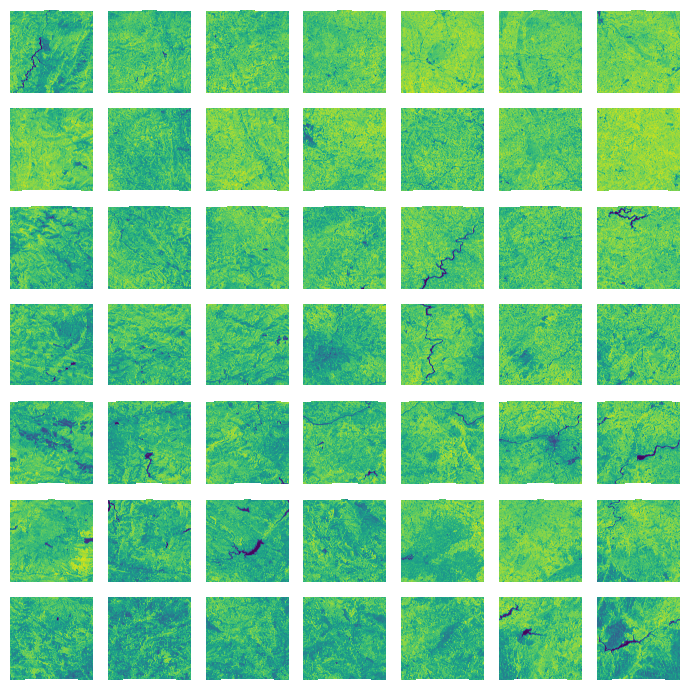

In [57]:
band = 4  # Change this to the desired band number

def load_and_plot_tif_files(folder_path, num_rows, num_cols, channel=band, save_path=None):
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 1, num_rows * 1))
    for i in range(num_rows):
        for j in trange(num_cols):
            file_name = f"galicia_split_image_{j}_{i}.tif"
            file_path = os.path.join(folder_path, file_name)
            axis_name = f"{i}_{j}"
            try:
                if os.path.exists(file_path):
                    dataset = gdal.Open(file_path)
                    if dataset is not None:
                        data = dataset.ReadAsArray()
                        # Check if data has at least 2 dimensions and enough channels
                        if data.ndim > 2 and data.shape[0] >= channel:
                            # Select one channel to display (0 by default)
                            ax = axs[i, j] if num_rows > 1 and num_cols > 1 else axs[max(i, j)]
                            im = ax.imshow(data[channel, :, :], cmap='viridis')
                            # ax.title.set_text(axis_name)
                            ax.axis('off')
                        else:
                            print(f"Data in {file_name} does not meet expected shape or channel count, skipping...")
                    else:
                        print(f"Failed to open {file_name}")
                else:
                    print(f"{file_name} not found.")
            except Exception as e:
                print(f"Failed to load {file_name}: {e}")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)  # Save the figure to a file
    plt.show()

folder_path = "/content/drive/MyDrive/17_sat_tif"  # Replace with the path to your .tif files
num_rows = 7    # Set the number of rows of the grid
num_cols = 7    # Set the number of columns of the grid
save_path = '/content/drive/MyDrive/visualisation.png'  # Specify the path to save the image
load_and_plot_tif_files(folder_path, num_rows, num_cols, channel=band, save_path=save_path)


### Removing the NaN values ans save new .tif

In [59]:
import os
import numpy as np
from osgeo import gdal, gdal_array

def remove_nan_rows(data):
    """Remove rows that contain NaN values from any band."""
    # Create a mask for rows without NaNs across all bands
    mask = ~np.isnan(data).any(axis=(0, 2))
    return data[:, mask, :]

def save_as_tif(data, file_path, original_dataset):
    """Save the NumPy array as a .tif file using the original dataset's metadata."""
    driver = gdal.GetDriverByName("GTiff")
    out_dataset = driver.Create(file_path, data.shape[2], data.shape[1], data.shape[0], gdal_array.NumericTypeCodeToGDALTypeCode(data.dtype))

    # Copy geo-transform and projection from the original dataset
    out_dataset.SetGeoTransform(original_dataset.GetGeoTransform())
    out_dataset.SetProjection(original_dataset.GetProjection())

    for i in range(data.shape[0]):
        out_dataset.GetRasterBand(i + 1).WriteArray(data[i])

    out_dataset.FlushCache()
    out_dataset = None

def process_and_save_tif_files(input_folder_path, output_folder_path, num_rows, num_cols):
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)

    for i in range(num_rows):
        for j in range(num_cols):
            file_name = f"galicia_split_image_{j}_{i}.tif"
            file_path = os.path.join(input_folder_path, file_name)
            output_file_path = os.path.join(output_folder_path, f"galicia_split_image_{j}_{i}.tif")
            try:
                if os.path.exists(file_path):
                    dataset = gdal.Open(file_path)
                    if dataset is not None:
                        data = dataset.ReadAsArray()
                        # Remove rows with NaN values from all bands
                        cleaned_data = remove_nan_rows(data)
                        # Save the cleaned data as a .tif file
                        save_as_tif(cleaned_data, output_file_path, dataset)
                        print(f"Processed and saved: {output_file_path}, new dimensions: {cleaned_data.shape}")
                    else:
                        print(f"Failed to open {file_name}")
                else:
                    print(f"{file_name} not found.")
            except Exception as e:
                print(f"Failed to process {file_name}: {e}")

input_folder_path = "/content/drive/MyDrive/17_sat_tif"  # Path to your original .tif files
output_folder_path = "/content/drive/MyDrive/17_sat_tif_processed"  # Path to save processed files
num_rows = 7  # Number of rows in the grid
num_cols = 7  # Number of columns in the grid

process_and_save_tif_files(input_folder_path, output_folder_path, num_rows, num_cols)


Processed and saved: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_0_0.tif, new dimensions: (5, 2403, 2403)
Processed and saved: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_1_0.tif, new dimensions: (5, 2403, 2404)
Processed and saved: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_2_0.tif, new dimensions: (5, 2403, 2403)
Processed and saved: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_3_0.tif, new dimensions: (5, 2403, 2404)
Processed and saved: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_4_0.tif, new dimensions: (5, 2403, 2403)
Processed and saved: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_5_0.tif, new dimensions: (5, 2403, 2403)
Processed and saved: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_6_0.tif, new dimensions: (5, 2403, 2404)
Processed and saved: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_0_1.tif, new dimensions: (5, 2403

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

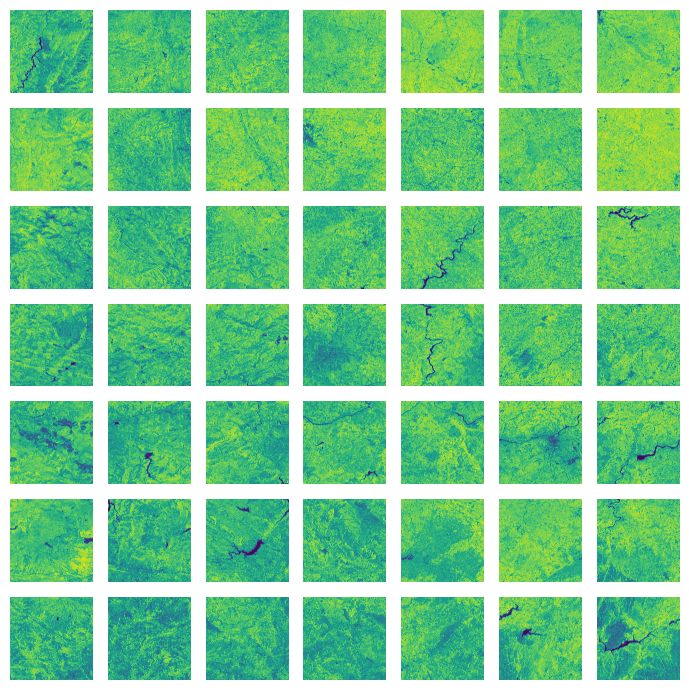

In [62]:
band = 4  # Change this to the desired band number

def load_and_plot_tif_files(folder_path, num_rows, num_cols, channel=band, save_path=None):
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 1, num_rows * 1))
    for i in range(num_rows):
        for j in trange(num_cols):
            file_name = f"galicia_split_image_{j}_{i}.tif"
            file_path = os.path.join(folder_path, file_name)
            axis_name = f"{i}_{j}"
            try:
                if os.path.exists(file_path):
                    dataset = gdal.Open(file_path)
                    if dataset is not None:
                        data = dataset.ReadAsArray()
                        # Check if data has at least 2 dimensions and enough channels
                        if data.ndim > 2 and data.shape[0] >= channel:
                            # Select one channel to display (0 by default)
                            ax = axs[i, j] if num_rows > 1 and num_cols > 1 else axs[max(i, j)]
                            im = ax.imshow(data[channel, :, :], cmap='viridis')
                            # ax.title.set_text(axis_name)
                            ax.axis('off')
                        else:
                            print(f"Data in {file_name} does not meet expected shape or channel count, skipping...")
                    else:
                        print(f"Failed to open {file_name}")
                else:
                    print(f"{file_name} not found.")
            except Exception as e:
                print(f"Failed to load {file_name}: {e}")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)  # Save the figure to a file
    plt.show()

folder_path = "/content/drive/MyDrive/17_sat_tif_processed"  # Replace with the path to your processed .tif files
num_rows = 7    # Set the number of rows of the grid
num_cols = 7    # Set the number of columns of the grid
save_path = '/content/drive/MyDrive/visualisation.png'  # Specify the path to save the image
load_and_plot_tif_files(folder_path, num_rows, num_cols, channel=band, save_path=save_path)


### Transforming images to Torch Tensors

In the first step we want to transform our images into PyTorch tensors so they are able to be fed into the model.

We have already slices all images into (almost) equal dimensions of 2404x2403 pixels. The target shape is (5, 2400, 2400).

Using the Geospatial Data Abstraction Library (GDAL), we can easily read the geospatial images we just downloaded from Google Earth Engine. Now we can read the raster data from the image and return it as an NumPy array to then store it into Torch tensor, with a .pt extension.

In [65]:
# Export images as new types (numpy and torch)
slices = 7
for idx in trange(slices):
    for jdx in trange(slices, leave=False):
        # Load image as array
        file_path_full = f"{file_path}_{idx}_{jdx}.tif"
        try:
            image_array = gdal.Open(file_path_full).ReadAsArray()
            print(f"--> image: {file_path_full} dimensions: {image_array.shape}")

            # Save image as torch
            file_path_torch = f"{file_path}_{idx}_{jdx}.pt"
            with open(file_path_torch, "wb") as f:
                torch.save(torch.tensor(image_array), f)
        except:
            print("File not found: ", file_path_full)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_0_0.tif dimensions: (5, 2403, 2403)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_0_1.tif dimensions: (5, 2403, 2403)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_0_2.tif dimensions: (5, 2403, 2403)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_0_3.tif dimensions: (5, 2403, 2403)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_0_4.tif dimensions: (5, 2402, 2403)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_0_5.tif dimensions: (5, 2403, 2403)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_0_6.tif dimensions: (5, 2403, 2403)


  0%|          | 0/7 [00:00<?, ?it/s]

--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_1_0.tif dimensions: (5, 2403, 2404)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_1_1.tif dimensions: (5, 2403, 2404)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_1_2.tif dimensions: (5, 2403, 2404)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_1_3.tif dimensions: (5, 2403, 2404)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_1_4.tif dimensions: (5, 2402, 2404)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_1_5.tif dimensions: (5, 2403, 2404)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_1_6.tif dimensions: (5, 2403, 2404)


  0%|          | 0/7 [00:00<?, ?it/s]

--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_2_0.tif dimensions: (5, 2403, 2403)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_2_1.tif dimensions: (5, 2403, 2403)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_2_2.tif dimensions: (5, 2403, 2403)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_2_3.tif dimensions: (5, 2403, 2403)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_2_4.tif dimensions: (5, 2402, 2403)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_2_5.tif dimensions: (5, 2403, 2403)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_2_6.tif dimensions: (5, 2403, 2403)


  0%|          | 0/7 [00:00<?, ?it/s]

--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_3_0.tif dimensions: (5, 2403, 2404)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_3_1.tif dimensions: (5, 2403, 2404)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_3_2.tif dimensions: (5, 2403, 2404)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_3_3.tif dimensions: (5, 2403, 2404)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_3_4.tif dimensions: (5, 2402, 2404)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_3_5.tif dimensions: (5, 2403, 2404)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_3_6.tif dimensions: (5, 2403, 2404)


  0%|          | 0/7 [00:00<?, ?it/s]

--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_4_0.tif dimensions: (5, 2403, 2403)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_4_1.tif dimensions: (5, 2403, 2403)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_4_2.tif dimensions: (5, 2403, 2403)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_4_3.tif dimensions: (5, 2403, 2403)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_4_4.tif dimensions: (5, 2402, 2403)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_4_5.tif dimensions: (5, 2403, 2403)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_4_6.tif dimensions: (5, 2403, 2403)


  0%|          | 0/7 [00:00<?, ?it/s]

--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_5_0.tif dimensions: (5, 2403, 2403)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_5_1.tif dimensions: (5, 2403, 2403)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_5_2.tif dimensions: (5, 2403, 2403)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_5_3.tif dimensions: (5, 2403, 2403)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_5_4.tif dimensions: (5, 2402, 2403)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_5_5.tif dimensions: (5, 2403, 2403)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_5_6.tif dimensions: (5, 2403, 2403)


  0%|          | 0/7 [00:00<?, ?it/s]

--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_6_0.tif dimensions: (5, 2403, 2404)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_6_1.tif dimensions: (5, 2403, 2404)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_6_2.tif dimensions: (5, 2403, 2404)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_6_3.tif dimensions: (5, 2403, 2404)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_6_4.tif dimensions: (5, 2402, 2404)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_6_5.tif dimensions: (5, 2403, 2404)
--> image: /content/drive/MyDrive/17_sat_tif_processed/galicia_split_image_6_6.tif dimensions: (5, 2403, 2404)


In [66]:
# Define the source and destination directories
source_dir = '/content/drive/MyDrive/17_sat_tif_processed'
destination_dir = '/content/drive/MyDrive/17_sat_pt'

# Ensure the destination directory exists, create if it doesn't
os.makedirs(destination_dir, exist_ok=True)

# Iterate over all files in the source directory
for filename in os.listdir(source_dir):
    if filename.endswith('.pt'):  # Check if the file has a .pt extension
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_dir, filename)

        # Move the file
        shutil.move(source_path, destination_path)
        print(f"Moved: {filename} to {destination_dir}")


Moved: galicia_split_image_0_0.pt to /content/drive/MyDrive/17_sat_pt
Moved: galicia_split_image_0_1.pt to /content/drive/MyDrive/17_sat_pt
Moved: galicia_split_image_0_2.pt to /content/drive/MyDrive/17_sat_pt
Moved: galicia_split_image_0_3.pt to /content/drive/MyDrive/17_sat_pt
Moved: galicia_split_image_0_4.pt to /content/drive/MyDrive/17_sat_pt
Moved: galicia_split_image_0_5.pt to /content/drive/MyDrive/17_sat_pt
Moved: galicia_split_image_0_6.pt to /content/drive/MyDrive/17_sat_pt
Moved: galicia_split_image_1_0.pt to /content/drive/MyDrive/17_sat_pt
Moved: galicia_split_image_1_1.pt to /content/drive/MyDrive/17_sat_pt
Moved: galicia_split_image_1_2.pt to /content/drive/MyDrive/17_sat_pt
Moved: galicia_split_image_1_3.pt to /content/drive/MyDrive/17_sat_pt
Moved: galicia_split_image_1_4.pt to /content/drive/MyDrive/17_sat_pt
Moved: galicia_split_image_1_5.pt to /content/drive/MyDrive/17_sat_pt
Moved: galicia_split_image_1_6.pt to /content/drive/MyDrive/17_sat_pt
Moved: galicia_split

In [67]:
# Define your input directories for satellite and ontology data
input_dir_satellite = "/content/drive/MyDrive/17_sat_pt"
output_dir_satellite = "/content/drive/MyDrive/17_sat_pt_processed"

os.makedirs(output_dir_satellite, exist_ok=True)  # Ensure the satellite output directory exists

# Get a list of all .pt files in the input directory that match satellite naming
files_satellite = [f for f in os.listdir(input_dir_satellite) if f.endswith('.pt') and not f.endswith('_ext.pt')]

# Function to process and save a single file
def process_and_save(file, input_dir, output_dir, is_ontology=False):
    # Load the image
    file_path = os.path.join(input_dir, file)
    image = torch.load(file_path)

    # Ensure image is truncated to 2400x2400
    truncated_image = image[:, :2400, :2400] if image.shape[1] > 2400 or image.shape[2] > 2400 else image

    # Construct the new file name
    base_name = file.split('.')[0]  # Remove .pt extension
    new_name = f"{base_name}.pt"  # Append .pt again to keep the extension

    # Save the processed image
    save_path = os.path.join(output_dir, new_name)
    torch.save(truncated_image, save_path)

    # Get the shape of the new tensors
    shape = truncated_image.shape

    # Print output for confirmation
    print(f"Processed and saved: {save_path}, new dimensions: {shape}")

# Process satellite images
for file in files_satellite:
    process_and_save(file, input_dir_satellite, output_dir_satellite)

Processed and saved: /content/drive/MyDrive/17_sat_pt_processed/galicia_split_image_0_0.pt, new dimensions: torch.Size([5, 2400, 2400])
Processed and saved: /content/drive/MyDrive/17_sat_pt_processed/galicia_split_image_0_1.pt, new dimensions: torch.Size([5, 2400, 2400])
Processed and saved: /content/drive/MyDrive/17_sat_pt_processed/galicia_split_image_0_2.pt, new dimensions: torch.Size([5, 2400, 2400])
Processed and saved: /content/drive/MyDrive/17_sat_pt_processed/galicia_split_image_0_3.pt, new dimensions: torch.Size([5, 2400, 2400])
Processed and saved: /content/drive/MyDrive/17_sat_pt_processed/galicia_split_image_0_4.pt, new dimensions: torch.Size([5, 2400, 2400])
Processed and saved: /content/drive/MyDrive/17_sat_pt_processed/galicia_split_image_0_5.pt, new dimensions: torch.Size([5, 2400, 2400])
Processed and saved: /content/drive/MyDrive/17_sat_pt_processed/galicia_split_image_0_6.pt, new dimensions: torch.Size([5, 2400, 2400])
Processed and saved: /content/drive/MyDrive/17_s

### Visualize tensors

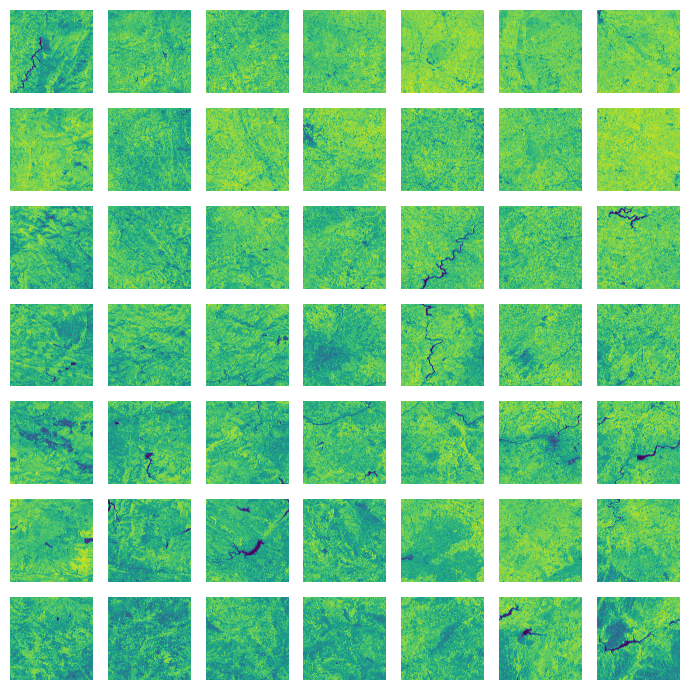

In [69]:
import torch
import matplotlib.pyplot as plt
import os

band = 4  # Change this to the desired band number

def load_and_plot_pt_files(folder_path, num_rows, num_cols, channel=band, save_path=None):
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 1, num_rows * 1))
    for i in range(num_rows):
        for j in range(num_cols):
         #   col_index = num_cols - 1 -j
            file_name = f"galicia_split_image_{j}_{i}.pt"
            file_path = os.path.join(folder_path, file_name)
            axis_name = f"{i}_{j}"
            try:
                if os.path.exists(file_path):
                    data = torch.load(file_path)
                    # Check if data has at least 2 dimensions and enough channels
                    if data.ndim > 2 and data.shape[0] >= channel:
                        # Select one channel to display (0 by default)
                        ax = axs[i, j] if num_rows > 1 and num_cols > 1 else axs[max(i, j)]
                        im = ax.imshow(data[channel, :, :], cmap='viridis')
                       # ax.title.set_text(axis_name)
                        ax.axis('off')
                    else:
                        print(f"Data in {file_name} does not meet expected shape or channel count, skipping...")
                else:
                    print(f"{file_name} not found.")
            except Exception as e:
                print(f"Failed to load {file_name}: {e}")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)  # Save the figure to a file
    plt.show()

folder_path = "/content/drive/MyDrive/17_sat_pt_processed"  # Replace with the path to your .pt files
num_rows = 7    # Set the number of rows of the grid
num_cols = 7    # Set the number of columns of the grid
save_path = '/content/drive/MyDrive/visualisation.png'  # Specify the path to save the image
load_and_plot_pt_files(folder_path, num_rows, num_cols, channel=band, save_path=save_path)


### Preparing correct dimensions 2400 --> 256

In [74]:
def process_tensors(input_dir, output_dir, original_size=(2400, 2400), patch_size=(256, 256)):
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over all files in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith('.pt'):  # Assuming the tensors are saved with '.pt' extension
            # Load the tensor
            tensor_path = os.path.join(input_dir, filename)
            tensor = torch.load(tensor_path)

            # Process each tensor
            row_idx = 0
            for i in trange(0, original_size[0], patch_size[0]):
                col_idx = 0
                for j in range(0, original_size[1], patch_size[1]):
                    # Check if the patch would be outside the bounds of the tensor
                    if i + patch_size[0] <= original_size[0] and j + patch_size[1] <= original_size[1]:
                        patch = crop(tensor, i, j, patch_size[0], patch_size[1])
                        # Ensure the patch is a separate tensor
                        patch = patch.clone()  # This makes sure the patch is a deep copy
                        # Naming patches based on row and column index
                        patch_filename = f"{filename[:-3]}_patch_{row_idx}_{col_idx}.pt"
                        patch_path = os.path.join(output_dir, patch_filename)
                        # Debug: Print patch info
                     #   print(f"Saving {patch_filename}: shape {patch.shape}, size on disk approx.")
                        torch.save(patch, patch_path)
                        col_idx += 1
                row_idx += 1
            print(f"Processed {filename} into patches, saved in {output_dir}")

# Define paths
input_dir = '/content/drive/MyDrive/17_sat_pt_processed'
output_dir = '/content/drive/MyDrive/17_sat_pt_256'

# Process the tensors
process_tensors(input_dir, output_dir)


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_0_0.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_0_1.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_0_2.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_0_3.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_0_4.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_0_5.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_0_6.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_1_0.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_1_1.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_1_2.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_1_3.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_1_4.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_1_5.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_1_6.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_2_0.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_2_1.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_2_2.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_2_3.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_2_4.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_2_5.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_2_6.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_3_0.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_3_1.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_3_2.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_3_3.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_3_4.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_3_5.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_3_6.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_4_0.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_4_1.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_4_2.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_4_3.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_4_4.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_4_5.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_4_6.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_5_0.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_5_1.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_5_2.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_5_3.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_5_4.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_5_5.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_5_6.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_6_0.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_6_1.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_6_2.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_6_3.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_6_4.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_6_5.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_6_6.pt into patches, saved in /content/drive/MyDrive/17_sat_pt_256


In [76]:
# checking the tensor shapes

def get_tensor_shape(file_path):
    """
    Load a tensor from the given file path and return its shape.

    Args:
    file_path (str): Path to the tensor file.

    Returns:
    torch.Size: Shape of the loaded tensor.
    """
    tensor = torch.load(file_path)
    return tensor.shape

file_path = '/content/drive/MyDrive/17_sat_pt_256/galicia_split_image_0_0_patch_0_0.pt'
tensor_shape = get_tensor_shape(file_path)
print(f"The shape of the tensor is: {tensor_shape}")

The shape of the tensor is: torch.Size([5, 256, 256])


# 2. Preprocessing Ontology Features

In [128]:
# Load image info
file_path = "/content/drive/MyDrive/17_sat_tif/galicia_split_image"
file_path_info = f"{file_path}.pickle"
with open(file_path_info, "rb") as f:
    coord_dict = pickle.load(f)
print(coord_dict)

{(0, 0): ((-6.711535, 43.308103), (-6.927347142857143, 43.09229085714286)), (0, 1): ((-6.711535, 43.09229085714286), (-6.927347142857143, 42.87647871428572)), (0, 2): ((-6.711535, 42.87647871428572), (-6.927347142857143, 42.66066657142857)), (0, 3): ((-6.711535, 42.66066657142857), (-6.927347142857143, 42.44485442857143)), (0, 4): ((-6.711535, 42.44485442857143), (-6.927347142857143, 42.229042285714286)), (0, 5): ((-6.711535, 42.229042285714286), (-6.927347142857143, 42.01323014285715)), (0, 6): ((-6.711535, 42.01323014285715), (-6.927347142857143, 41.797418)), (1, 0): ((-6.927347142857143, 43.308103), (-7.143159285714286, 43.09229085714286)), (1, 1): ((-6.927347142857143, 43.09229085714286), (-7.143159285714286, 42.87647871428572)), (1, 2): ((-6.927347142857143, 42.87647871428572), (-7.143159285714286, 42.66066657142857)), (1, 3): ((-6.927347142857143, 42.66066657142857), (-7.143159285714286, 42.44485442857143)), (1, 4): ((-6.927347142857143, 42.44485442857143), (-7.143159285714286, 4

In [127]:
# Feature ontology path
ont_dir = "ont_pickles"
folder_path = f"{drive_path}/MyDrive/{ont_dir}"

file_name = "ont_features"
file_path = f"{folder_path}/{file_name}"

In [113]:
for idx in trange(slices):
    for jdx in trange(slices, leave=False):
        file_path_pandas = f"{file_path}_{idx}_{jdx}.pickle"
        data = pd.read_pickle(file_path_pandas)
        if idx == 0 and jdx == 0:
            data_whole = data
        else:
            data_whole = pd.concat([data_whole, data], axis=0)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [114]:
def get_matching_index(lat_tree, lon_tree, coord_dict):
    for key, ((max_lat, max_lon), (min_lat, min_lon)) in coord_dict.items():
        test_1 = min_lon <= float(lon_tree) <= max_lon
        test_2 = min_lat <= float(lat_tree) <= max_lat
        if test_1 and test_2:
            return key
    raise ValueError(f"No bounding box contains the point: {lat_tree}, {lon_tree}")

In [115]:
sorted_indices = {key: [] for key in coord_dict.keys()}

for idx in tqdm(range(len(data_whole))):
    # Get data item
    data_i = data_whole.iloc[idx]

    # Get longitute and latitute of tree
    lat_tree, lon_tree = data_i["xcoord"], data_i["ycoord"]

    # Check in which area the tree falls
    image_index = get_matching_index(lat_tree, lon_tree, coord_dict)

    # Store idx to image_index mapping
    sorted_indices[image_index].append(idx)

  0%|          | 0/39013 [00:00<?, ?it/s]

In [131]:
def geo_to_pixel(lat, lon, lat_range, lon_range, img_dimensions):
    """
    Convert geographical coordinates to pixel coordinates on a map image.

    Parameters:
    - lat, lon: float, geographical coordinates (latitude and longitude)
    - lat_range: tuple, (min_latitude, max_latitude)
    - lon_range: tuple, (min_longitude, max_longitude)
    - img_dimensions: tuple, (width, height) of the image in pixels

    Returns:
    - (x, y): tuple, pixel coordinates corresponding to the geographical location
    """
    min_lat, max_lat = lat_range
    min_lon, max_lon = lon_range
    width, height = img_dimensions

    # Calculate the relative position of the coordinates within the range
    lat_percent = (lat - min_lat) / (max_lat - min_lat)
    lon_percent = (lon - min_lon) / (max_lon - min_lon)

    # Convert to pixel coordinates
    # Note: Pixel (0,0) is at the top-left corner, so we invert the y coordinate
    x = int(lon_percent * width)
    y = int((1 - lat_percent) * height)

    return (x, y)


def expanded_assign(target_layer, px, py, data, radius=150):
    norm_r = radius // 2
    max_x, max_y = target_layer.shape

    # Calculate bounds for the area to update
    min_x = max(0, px - norm_r)
    max_x = min(max_x, px + norm_r)
    min_y = max(0, py - norm_r)
    max_y = min(max_y, py + norm_r)

    # Use slicing to update the sub-matrix in one operation
    target_layer[min_x:max_x, min_y:max_y] += data

    return target_layer

In [135]:
# File path setup
img_dir = "17_sat_pt_processed"
folder_path = f"{drive_path}/MyDrive/{img_dir}"

# Image path & scale for Sentinel-2A download
file_name = "galicia_split_image"  # Name of the .tif file
file_path = f"{folder_path}/{file_name}"
scale = 10  # pixels per meter
AS_TYPE = torch.float32
slices = 7

In [136]:
new_dims = 3

for image_index, idx_list in tqdm(sorted_indices.items()):
    # Get range of coordinates by image
    ((max_lat, max_lon), (min_lat, min_lon)) = coord_dict[image_index]
    lat_range, lon_range = (min_lat, max_lat), (min_lon, max_lon)

    # Save image as torch
    idx, jdx = image_index
    file_path_torch = f"{file_path}_{idx}_{jdx}.pt"
    try:
        image = torch.load(file_path_torch)
    except FileNotFoundError:
        print("File not found: ", file_path_torch)
        continue

    # Create empty onotology layers
    depth, width, height = image.shape
    target_layer = torch.zeros((new_dims, width, height)).to(AS_TYPE)

    for i in idx_list:
        # Get data item
        data_i = data_whole.iloc[i]

        # Get longitute and latitute of tree
        lat_tree, lon_tree = data_i["xcoord"], data_i["ycoord"]

        # Find mapping of pixel
        px, py = geo_to_pixel(lat_tree, lon_tree, lat_range, lon_range, (width, height))

        # Populate ontology layers w/ values
        target_layer[0, :, :] = expanded_assign(
            target_layer[0, :, :], px, py, data_i["height"]
        )
        target_layer[1, :, :] = expanded_assign(
            target_layer[1, :, :], px, py, data_i["firewood"]
        )
        target_layer[2, :, :] = expanded_assign(
            target_layer[2, :, :], px, py, data_i["species_number"]
        )

    image = np.vstack((image, target_layer))
    torch.save(torch.tensor(image), f"{file_path}_{idx}_{jdx}_ext.pt")

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

--> image: /content/drive/MyDrive/17_sat_pt_processed/galicia_split_image_0_0_ext.pt dimensions: torch.Size([8, 2400, 2400])


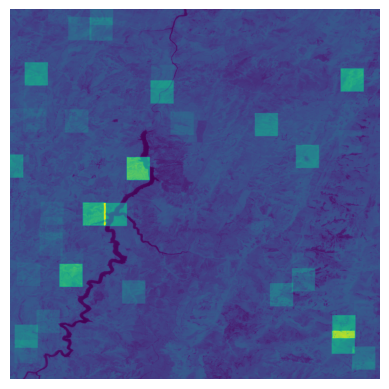

In [142]:
import os
slices = 7
band = 4

for idx in trange(slices):
    for jdx in trange(slices, leave=False):
        file_path_torch_ext = f"{file_path}_{idx}_{jdx}_ext.pt"
        try:
            image_array = torch.load(file_path_torch_ext)
            print(f"--> image: {file_path_torch_ext} dimensions: {image_array.shape}")
            img = image_array[band, :, :] * 10
            img += image_array[5, :, :]
            plt.imshow(img, cmap="viridis")
            plt.axis("off")
            plt.show()
            break
            axs[slices - jdx - 1, idx].imshow(img, cmap="viridis")
            axs[slices - jdx - 1, idx].axis("off")
        except FileNotFoundError:
            print("File not found: ", file_path_torch_ext)
        break
    break

In [143]:
# Define the source and destination directories
source_dir = '/content/drive/MyDrive/17_sat_pt_processed'
destination_dir = '/content/drive/MyDrive/17_ont_pt_processed'

# Ensure the destination directory exists, create if it doesn't
os.makedirs(destination_dir, exist_ok=True)

# Iterate over all files in the source directory
for filename in os.listdir(source_dir):
    if filename.endswith('_ext.pt'):  # Check if the file has a .pt extension
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_dir, filename)

        # Move the file
        shutil.move(source_path, destination_path)
        print(f"Moved: {filename} to {destination_dir}")

Moved: galicia_split_image_0_0_ext.pt to /content/drive/MyDrive/17_pt_processed_ont
Moved: galicia_split_image_0_1_ext.pt to /content/drive/MyDrive/17_pt_processed_ont
Moved: galicia_split_image_0_2_ext.pt to /content/drive/MyDrive/17_pt_processed_ont
Moved: galicia_split_image_0_3_ext.pt to /content/drive/MyDrive/17_pt_processed_ont
Moved: galicia_split_image_0_4_ext.pt to /content/drive/MyDrive/17_pt_processed_ont
Moved: galicia_split_image_0_5_ext.pt to /content/drive/MyDrive/17_pt_processed_ont
Moved: galicia_split_image_0_6_ext.pt to /content/drive/MyDrive/17_pt_processed_ont
Moved: galicia_split_image_1_0_ext.pt to /content/drive/MyDrive/17_pt_processed_ont
Moved: galicia_split_image_1_1_ext.pt to /content/drive/MyDrive/17_pt_processed_ont
Moved: galicia_split_image_1_2_ext.pt to /content/drive/MyDrive/17_pt_processed_ont
Moved: galicia_split_image_1_3_ext.pt to /content/drive/MyDrive/17_pt_processed_ont
Moved: galicia_split_image_1_4_ext.pt to /content/drive/MyDrive/17_pt_proces

In [146]:
def process_tensors(input_dir, output_dir, original_size=(2400, 2400), patch_size=(256, 256)):
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over all files in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith('.pt'):  # Assuming the tensors are saved with '.pt' extension
            # Load the tensor
            tensor_path = os.path.join(input_dir, filename)
            tensor = torch.load(tensor_path)

            # Process each tensor
            row_idx = 0
            for i in trange(0, original_size[0], patch_size[0]):
                col_idx = 0
                for j in range(0, original_size[1], patch_size[1]):
                    # Check if the patch would be outside the bounds of the tensor
                    if i + patch_size[0] <= original_size[0] and j + patch_size[1] <= original_size[1]:
                        patch = crop(tensor, i, j, patch_size[0], patch_size[1])
                        # Ensure the patch is a separate tensor
                        patch = patch.clone()  # This makes sure the patch is a deep copy
                        # Naming patches based on row and column index
                        patch_filename = f"{filename[:-3]}_patch_{row_idx}_{col_idx}.pt"
                        patch_path = os.path.join(output_dir, patch_filename)
                        # Debug: Print patch info
                     #   print(f"Saving {patch_filename}: shape {patch.shape}, size on disk approx.")
                        torch.save(patch, patch_path)
                        col_idx += 1
                row_idx += 1
            print(f"Processed {filename} into patches, saved in {output_dir}")

# Define paths
input_dir = '/content/drive/MyDrive/17_ont_pt_processed'
output_dir = '/content/drive/MyDrive/17_ont_pt_256'

# Process the tensors
process_tensors(input_dir, output_dir)


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_0_0_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_0_1_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_0_2_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_0_3_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_0_4_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_0_5_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_0_6_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_1_0_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_1_1_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_1_2_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_1_3_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_1_4_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_1_5_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_1_6_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_2_0_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_2_1_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_2_2_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_2_3_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_2_4_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_2_5_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_2_6_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_3_0_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_3_1_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_3_2_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_3_3_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_3_4_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_3_5_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_3_6_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_4_0_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_4_1_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_4_2_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_4_3_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_4_4_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_4_5_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_4_6_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_5_0_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_5_1_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_5_2_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_5_3_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_5_4_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_5_5_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_5_6_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_6_0_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_6_1_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_6_2_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_6_3_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_6_4_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_6_5_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


  0%|          | 0/10 [00:00<?, ?it/s]

Processed galicia_split_image_6_6_ext.pt into patches, saved in /content/drive/MyDrive/17_ont_pt_256


## Visualizing patches

### One patch

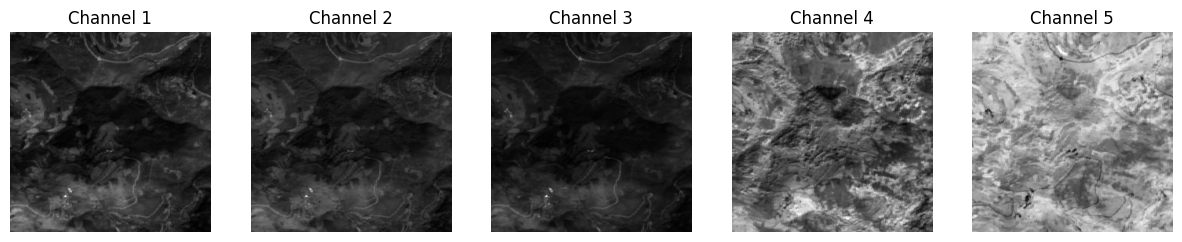

In [150]:
import torch
import matplotlib.pyplot as plt

def visualize_tensor(path):
    # Load the tensor
    tensor = torch.load(path)

    # Normalize the tensor to 0-1 range for visualization
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())

    # Number of channels in the tensor
    num_channels = tensor.shape[0]

    # Create a figure with subplots
    fig, axes = plt.subplots(1, num_channels, figsize=(15, 5))  # Adjust the figure size as needed

    for i in range(num_channels):
        ax = axes[i]
        # Select the channel and convert it to numpy for visualization
        channel_image = tensor[i].numpy()
        # Display the image
        ax.imshow(channel_image, cmap='gray')  # Using grayscale colormap
        ax.axis('off')  # Turn off axis numbers and ticks
        ax.set_title(f'Channel {i+1}')

    plt.show()

# Define the path to the tensor
path = '/content/drive/MyDrive/17_sat_pt_256/galicia_split_image_0_2_patch_0_0.pt'

# Visualize the tensor
visualize_tensor(path)

### One row of patches

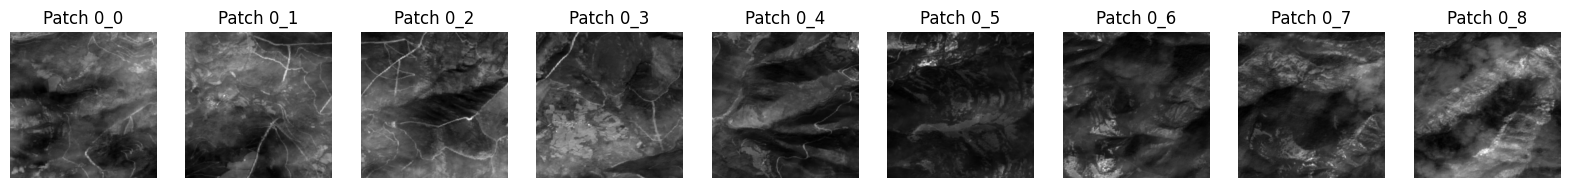

In [152]:
import torch
import matplotlib.pyplot as plt

def visualize_patches(base_path, file_prefix, start_patch, end_patch):
    # Normalize and visualize each patch from patch_0_0 to patch_0_8
    fig, axes = plt.subplots(1, end_patch - start_patch + 1, figsize=(20, 4))  # Adjust size as needed

    for idx, ax in enumerate(axes):
        patch_num = start_patch + idx
        # Construct full path to the tensor
        path = f"{base_path}/{file_prefix}_patch_0_{patch_num}.pt"
        tensor = torch.load(path)

        # Normalize the tensor to 0-1 range for visualization
        tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())

        # Assuming the tensor's shape is [C, H, W] and it has more than 1 channel
        # For simplicity, just visualize the first channel
        channel_image = tensor[0].numpy()  # Using the first channel

        # Display the image
        ax.imshow(channel_image, cmap='gray')  # Using grayscale colormap
        ax.axis('off')  # Turn off axis numbers and ticks
        ax.set_title(f'Patch 0_{patch_num}')

    plt.show()


# Base path to the patches
base_path = '/content/drive/MyDrive/17_sat_pt_256/'
# Prefix in the filename before patch identifiers
file_prefix = 'galicia_split_image_0_1'                               # some trouble with 0_2?
# Start and end indices for the patches
start_patch = 0
end_patch = 8

# Visualize the patches
visualize_patches(base_path, file_prefix, start_patch, end_patch)


### One entire tensor with 96 patches

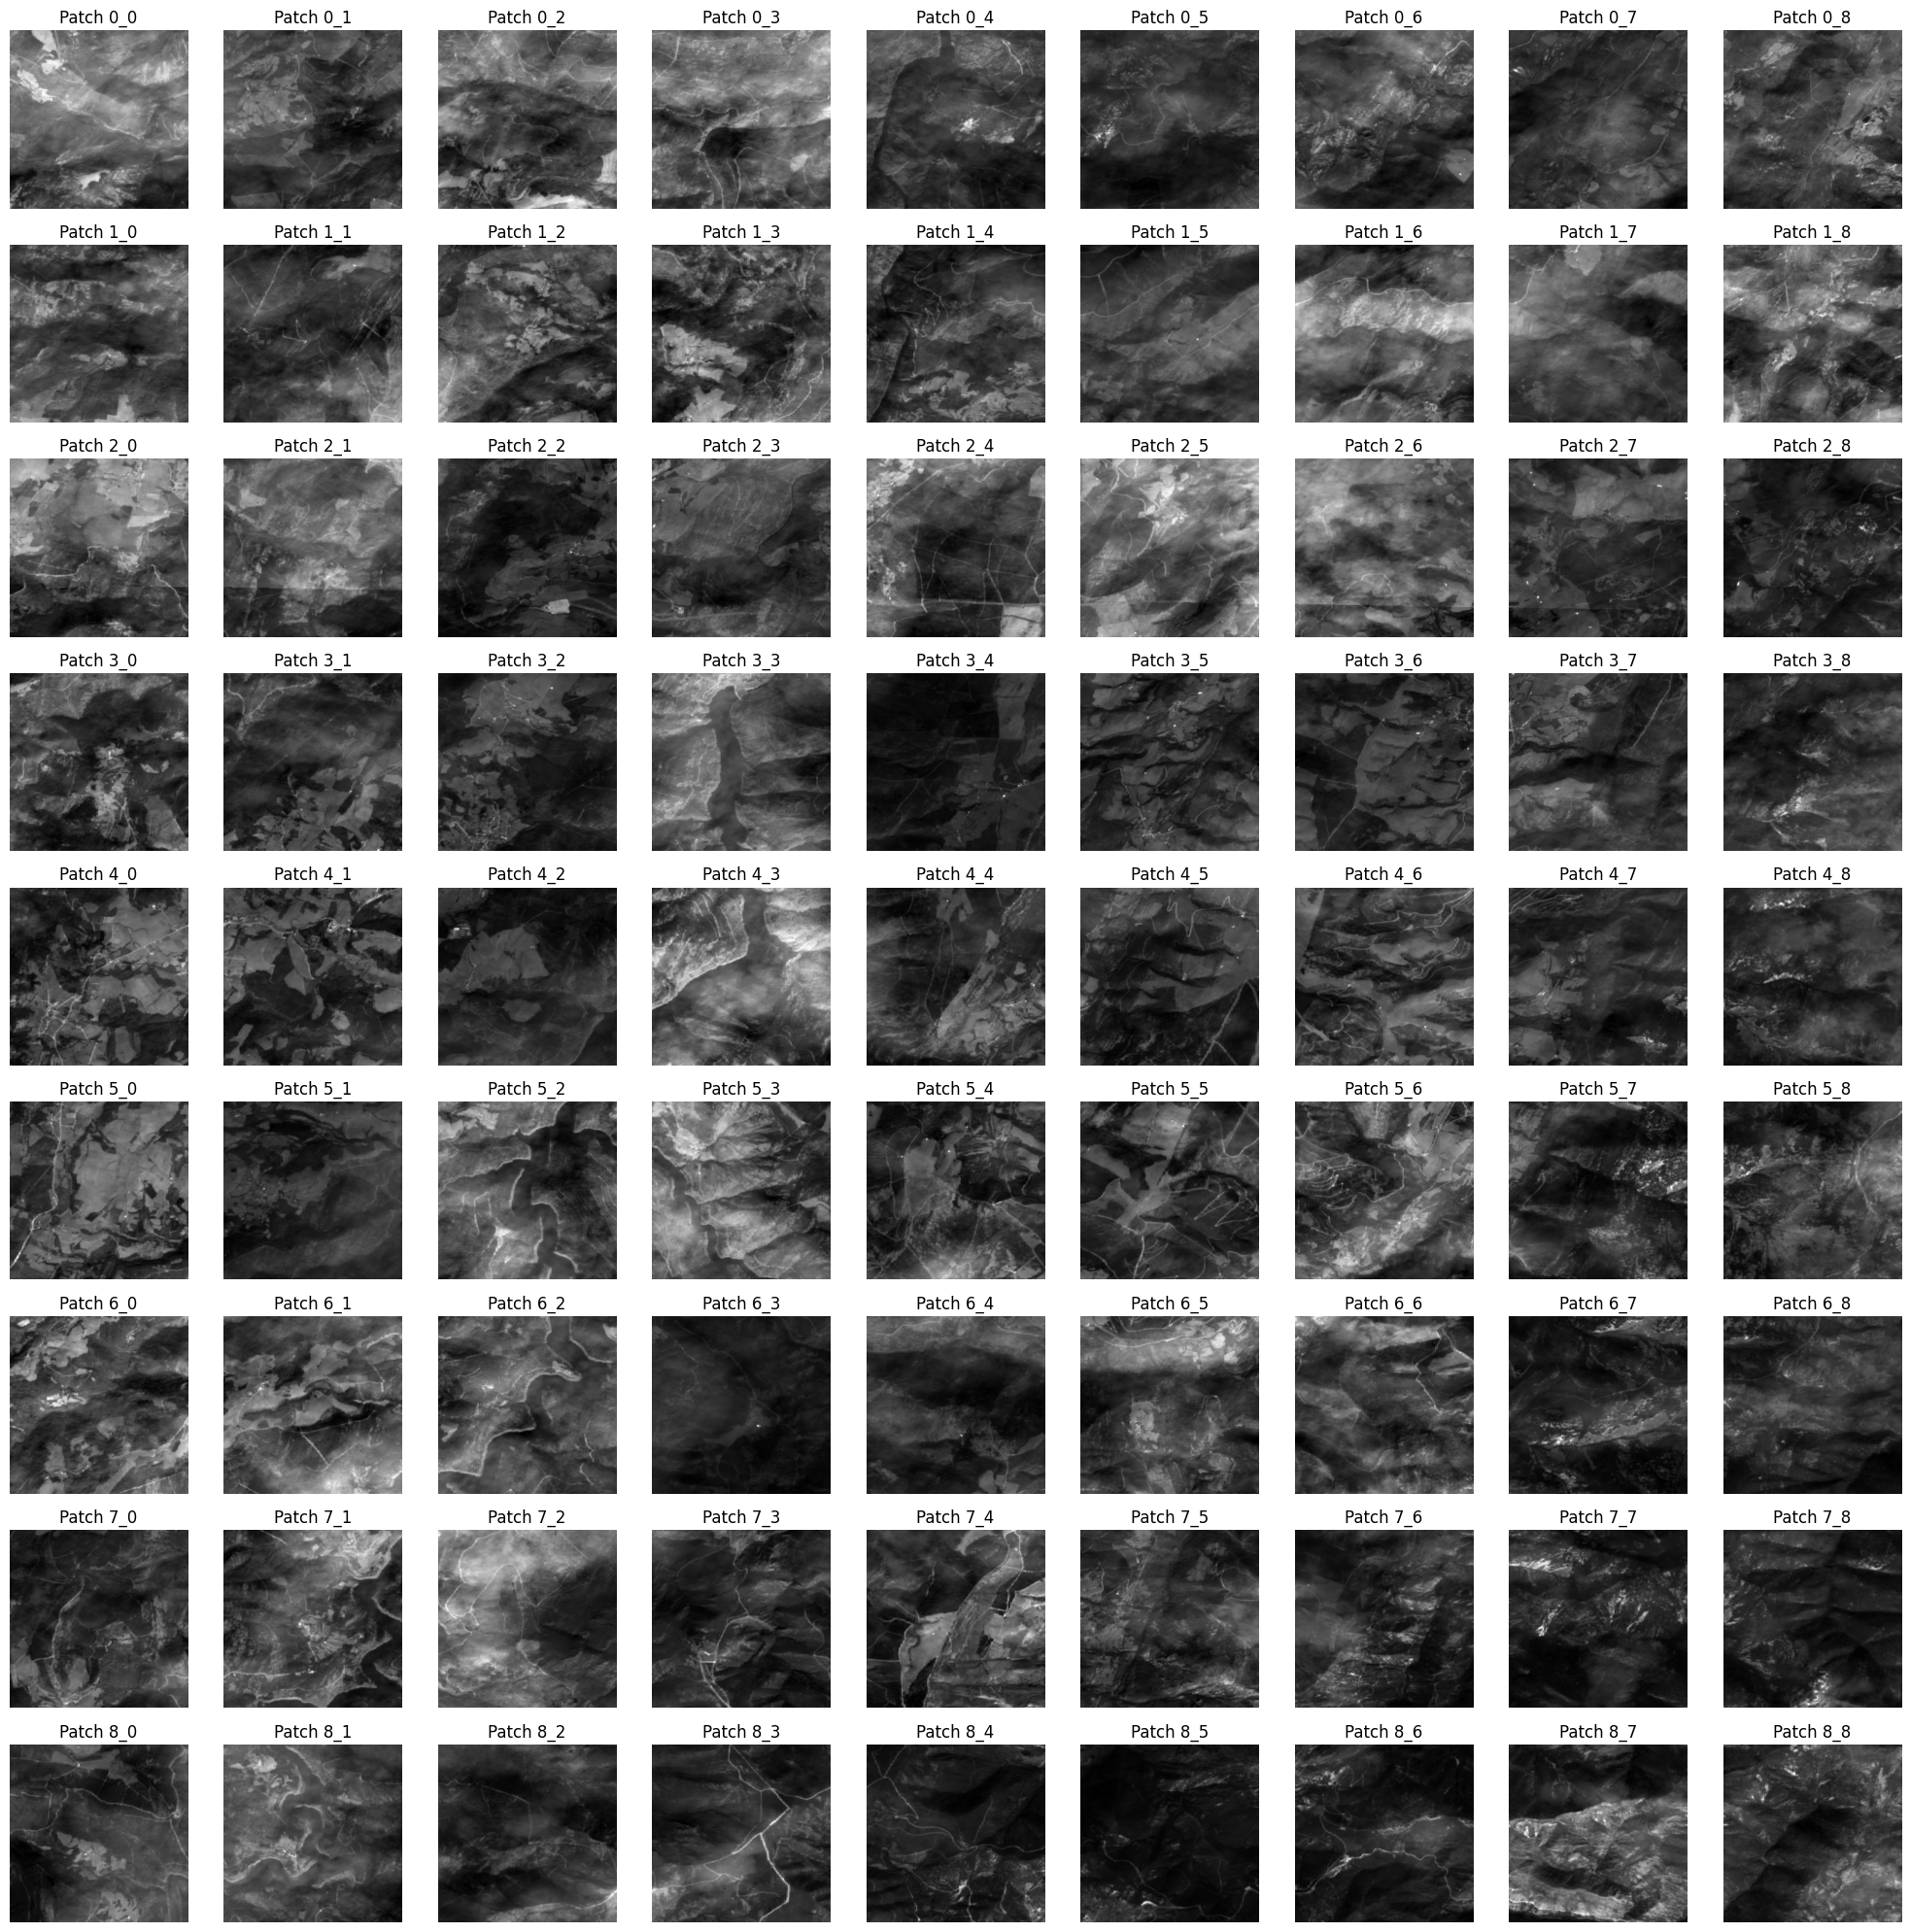

In [153]:
import torch
import matplotlib.pyplot as plt
import os

def reconstruct_tensor(base_path, file_prefix):
    # Define the size of the original tensor and the patches
    original_size = (5, 2400, 2400)  # Assuming 5 channels
    patch_size = (5, 256, 256)
    patches_per_dim = 9

    # Create an empty tensor to hold the reconstructed image
    reconstructed_tensor = torch.zeros(original_size)

    # Iterate over each patch position
    for row_idx in range(patches_per_dim):
        for col_idx in range(patches_per_dim):
            # Construct the full path to the tensor
            path = f"{base_path}/{file_prefix}_patch_{row_idx}_{col_idx}.pt"
            if os.path.exists(path):
                patch = torch.load(path)

                # Determine where this patch goes in the reconstructed tensor
                row_start = row_idx * patch_size[1]
                col_start = col_idx * patch_size[2]
                row_end = row_start + patch_size[1]
                col_end = col_start + patch_size[2]

                # Place the patch in the correct location in the reconstructed tensor
                reconstructed_tensor[:, row_start:row_end, col_start:col_end] = patch
            else:
                print(f"Patch {row_idx}_{col_idx} not found. Skipping.")

    return reconstructed_tensor

def visualize_patches_in_grid(base_path, file_prefix):
    # Define the size of the patches
    patch_size = (5, 256, 256)
    patches_per_dim = 9

    # Prepare the figure for visualization
    fig, axes = plt.subplots(patches_per_dim, patches_per_dim, figsize=(20, 20))  # Adjust size as needed

    for row_idx in range(patches_per_dim):
        for col_idx in range(patches_per_dim):
            ax = axes[row_idx, col_idx]
            # Construct full path to the tensor
            path = f"{base_path}/{file_prefix}_patch_{row_idx}_{col_idx}.pt"
            if os.path.exists(path):
                tensor = torch.load(path)

                # Normalize the tensor to 0-1 range for visualization
                tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())

                # Use the first channel for visualization
                channel_image = tensor[0].numpy()  # Using the first channel

                # Display the image
                ax.imshow(channel_image, cmap='gray')  # Using grayscale colormap
                ax.axis('off')  # Turn off axis numbers and ticks
                ax.set_title(f'Patch {row_idx}_{col_idx}')
            else:
                ax.axis('off')  # Hide the axis if patch is not found
                ax.set_title(f'Missing {row_idx}_{col_idx}')

    plt.tight_layout()
    plt.show()

# Base path to the patches
base_path = '/content/drive/MyDrive/17_sat_pt_256'
# Prefix in the filename before patch identifiers
file_prefix = 'galicia_split_image_0_0'

# Visualize patches in a grid layout
visualize_patches_in_grid(base_path, file_prefix)
